In [155]:
#Goal: Have to build a multiple linear regression model for the prediction of demand for shared bikes. 

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [157]:
#Collect & Explore the Dataset

In [158]:
#Load the dataset 
df=pd.read_csv("day.csv")
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

#Explore the Dataset
df.shape

In [159]:
df.shape

(730, 16)

In [160]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [161]:
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [162]:
#Continuous variables:  temp, atemp, hum, windspeed

#Categorical variables:
    # - Nominal vars(no order): Season, year, month, Holiday, weekday, workingday, weathersit

#columns to be dropped: instant(not useful),dteday(can be broken into date only as we already have month and year information), registered and causual(they are included in cnt)

In [163]:
df['dteday']=pd.to_datetime(df['dteday'], format='%d-%m-%Y')

In [164]:
df['day']=df['dteday'].dt.day

In [165]:
df.drop(columns=['instant','registered','casual','dteday'], axis=1, inplace=True)

In [166]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,1
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,2
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,3
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,4
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,5


In [167]:
#Mapping Categorical variables to their labels
print(df["mnth"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [168]:
season={1:"spring", 2:"summer", 3:"fall", 4:"winter"}
df['season']=df['season'].map(season)

In [169]:
weathersit={1:"Clear",2:"Mist/Cloudy",3:"Light Rain/Snow",4:"Heavy Rain/Snow"}

In [170]:
df["weathersit"]=df["weathersit"].map(weathersit)
df.dtypes

season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
day             int32
dtype: object

In [171]:

mnth_map = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June", 
            7:"July", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}


df["mnth"] = df["mnth"].map(mnth_map)

print(df["mnth"].unique())  # Check if mapping worked

print(df["workingday"].unique()) 

['Jan' 'Feb' 'Mar' 'Apr' 'May' 'June' 'July' 'Aug' 'Sept' 'Oct' 'Nov'
 'Dec']
[0 1]


In [172]:
#Check for Multicollinearity
weekday_map = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

df["weekday"] = df["weekday"].map(weekday_map)


In [173]:
df["weekday"].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [174]:
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,spring,0,Jan,0,Saturday,0,Mist/Cloudy,14.110847,18.18125,80.5833,10.749882,985,1
1,spring,0,Jan,0,Sunday,0,Mist/Cloudy,14.902598,17.68695,69.6087,16.652113,801,2
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,3
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,4
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Thursday,1,Mist/Cloudy,10.420847,11.33210,65.2917,23.458911,2114,27
726,spring,1,Dec,0,Friday,1,Mist/Cloudy,10.386653,12.75230,59.0000,10.416557,3095,28
727,spring,1,Dec,0,Saturday,0,Mist/Cloudy,10.386653,12.12000,75.2917,8.333661,1341,29
728,spring,1,Dec,0,Sunday,0,Clear,10.489153,11.58500,48.3333,23.500518,1796,30


In [175]:
#Univariate analysis of Categorical variables (nominal variables:season, mnth, weekday,weathersit)

<Axes: xlabel='season', ylabel='cnt'>

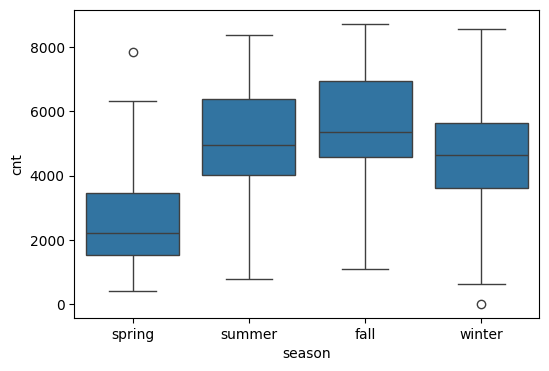

In [176]:
plt.figure(figsize=(6,4))
sns.boxplot(x="season",y="cnt",data=df)

<Axes: xlabel='mnth', ylabel='cnt'>

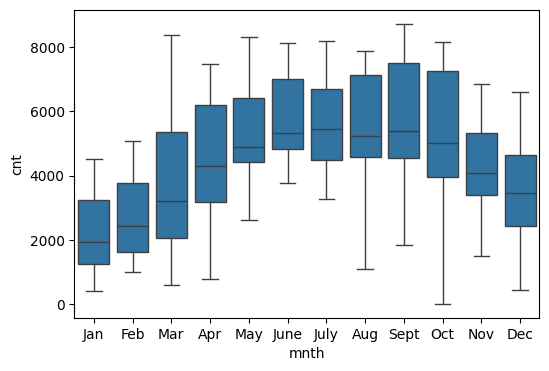

In [177]:
plt.figure(figsize=(6,4))
sns.boxplot(x="mnth",y="cnt",data=df)

In [178]:
#Above 2 graphs shows highest bookings during Fall season (mid Aug to mid Oct)

<Axes: xlabel='weekday', ylabel='cnt'>

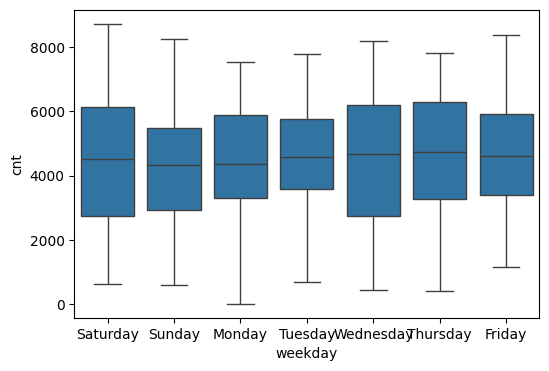

In [179]:
plt.figure(figsize=(6,4))
sns.boxplot(x="weekday",y="cnt",data=df)

In [180]:
#Insight: All weekdays have almost same median

<Axes: xlabel='weathersit', ylabel='cnt'>

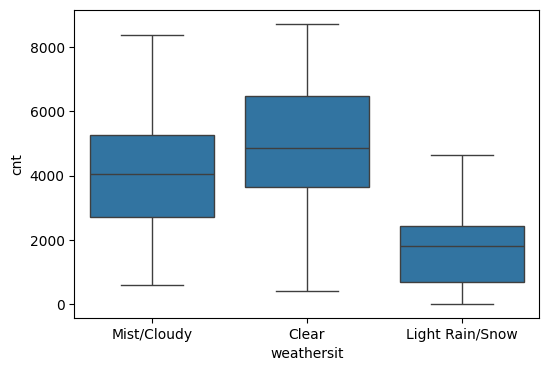

In [181]:
plt.figure(figsize=(6,4))
sns.boxplot(x="weathersit",y="cnt",data=df)

In [182]:
#Insight: from above diagram , weather has an impact on bookings. "Clear" weather has most number of booking with lowest in "Light rainy". 
#"Heavy rainy day" does not have any booking

<Axes: xlabel='yr', ylabel='cnt'>

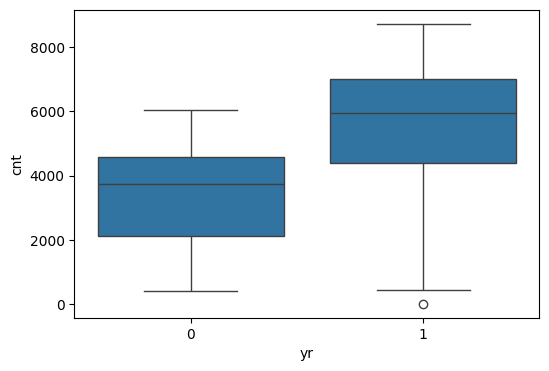

In [183]:
plt.figure(figsize=(6,4))
sns.boxplot(x="yr",y="cnt",data=df)

In [184]:
#Insight: from above diagram , it shows that during year 2018, company is just establishing so has less bookings compared to bookings in 2019

<Axes: xlabel='temp', ylabel='Count'>

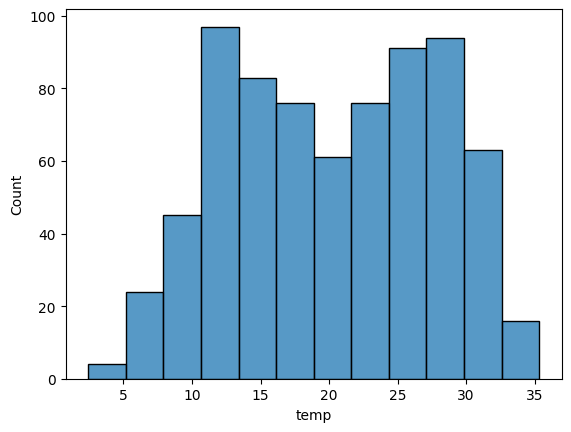

In [185]:

#Univariate analysis: Continuous variables
sns.histplot(df["temp"])

In [186]:
#Insight: temp field is not showing clear indication whether bookings are decreasing or increasing with temperature. 


In [187]:
df.dtypes
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,spring,0,Jan,0,Saturday,0,Mist/Cloudy,14.110847,18.18125,80.5833,10.749882,985,1
1,spring,0,Jan,0,Sunday,0,Mist/Cloudy,14.902598,17.68695,69.6087,16.652113,801,2
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,3
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,4
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Thursday,1,Mist/Cloudy,10.420847,11.33210,65.2917,23.458911,2114,27
726,spring,1,Dec,0,Friday,1,Mist/Cloudy,10.386653,12.75230,59.0000,10.416557,3095,28
727,spring,1,Dec,0,Saturday,0,Mist/Cloudy,10.386653,12.12000,75.2917,8.333661,1341,29
728,spring,1,Dec,0,Sunday,0,Clear,10.489153,11.58500,48.3333,23.500518,1796,30


In [188]:
#Multivariate analysis : Heatmap

In [189]:
df_num=df.select_dtypes(include="number")

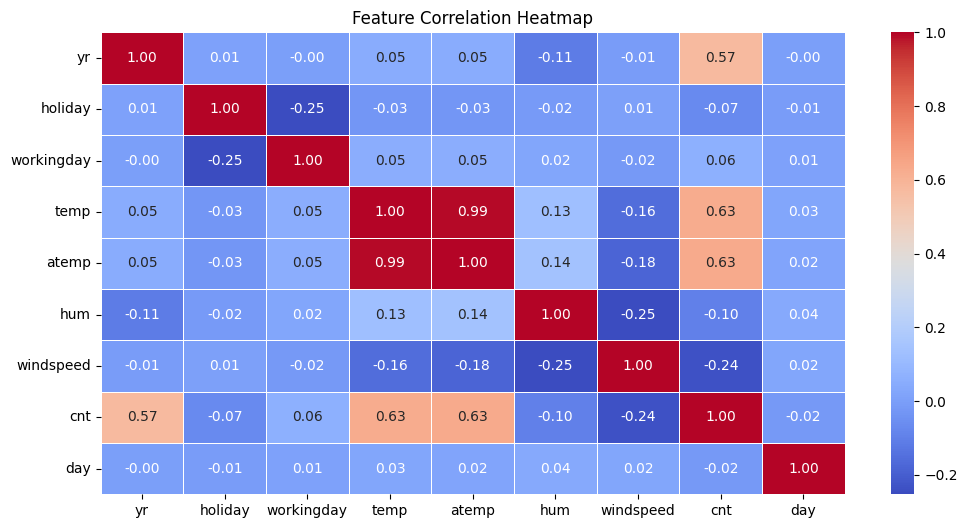

In [190]:
corr_matrix = df_num.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [191]:
# Insight:  From above diagram, couple of observations:                                                                                                                                                      
#1) temp and atemp are highly correlated and we can drop "atemp" because it will not give any additional insight
#2) hum and cnt has very weak -ve correlation, we can verify it by drawing scatter plot
#3) day cannot be treated as conitnuous var, we can create boxplot with "cnt" variable
#4)temp and cnt has strong correlation

In [192]:
#VIF analysis
df_continuous= df[['atemp', 'temp', 'hum','windspeed']]  # Independent continuous variables
vif_data = pd.DataFrame()
vif_data["Feature"] = df_continuous.columns
vif_data["VIF"] = [variance_inflation_factor(df_continuous.values, i) for i in range(len(df_continuous.columns))]
print(vif_data)

     Feature         VIF
0      atemp  542.888840
1       temp  488.306256
2        hum   11.071034
3  windspeed    4.678072


In [193]:
df.drop(columns=["atemp"], axis=1, inplace= True)

In [194]:
#VIF analysis post dropping atemp
df_continuous= df[[ 'temp', 'hum','windspeed']]  # Independent continuous variables
vif_data = pd.DataFrame()
vif_data["Feature"] = df_continuous.columns
vif_data["VIF"] = [variance_inflation_factor(df_continuous.values, i) for i in range(len(df_continuous.columns))]
print(vif_data)

     Feature       VIF
0       temp  7.132959
1        hum  9.052993
2  windspeed  4.677354


In [195]:
#VIF reduced, keep temp, hum, and windspeed for now but will further monitor/analyze temp and hum fields

<Axes: xlabel='hum', ylabel='cnt'>

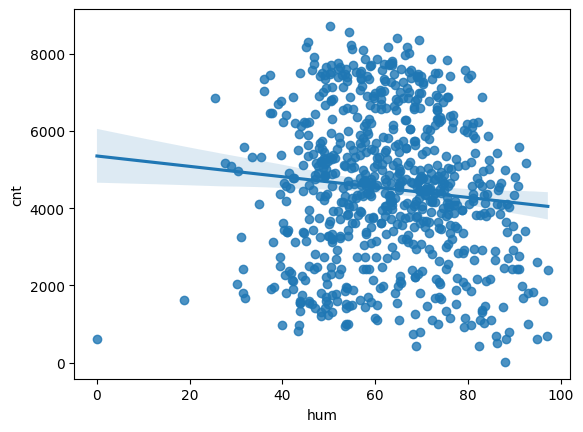

In [197]:
#Insight: hum and cnt scatter plot , as per below plot, "hum" does not have very significant impact on bookings
sns.regplot(x="hum", y="cnt", data=df)

In [198]:
df.drop(columns=['day','hum'], axis=1, inplace=True)
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist/Cloudy,14.110847,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist/Cloudy,14.902598,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Thursday,1,Mist/Cloudy,10.420847,23.458911,2114
726,spring,1,Dec,0,Friday,1,Mist/Cloudy,10.386653,10.416557,3095
727,spring,1,Dec,0,Saturday,0,Mist/Cloudy,10.386653,8.333661,1341
728,spring,1,Dec,0,Sunday,0,Clear,10.489153,23.500518,1796


In [199]:
df.describe()

,yr,holiday,workingday,temp,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,12.763620,4508.006849
std,0.500343,0.167266,0.465405,7.506729,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,34.000021,8714.000000


In [200]:
#Insight: from above distribution, we can see that temp and windspeed variables' mean and median values are almost equal i.e. data is normally distributed for them

In [201]:
df.shape

(730, 10)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   windspeed   730 non-null    float64
 9   cnt         730 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 57.2+ KB


In [203]:
#Bivariate analysis  
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist/Cloudy,14.110847,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist/Cloudy,14.902598,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Thursday,1,Mist/Cloudy,10.420847,23.458911,2114
726,spring,1,Dec,0,Friday,1,Mist/Cloudy,10.386653,10.416557,3095
727,spring,1,Dec,0,Saturday,0,Mist/Cloudy,10.386653,8.333661,1341
728,spring,1,Dec,0,Sunday,0,Clear,10.489153,23.500518,1796


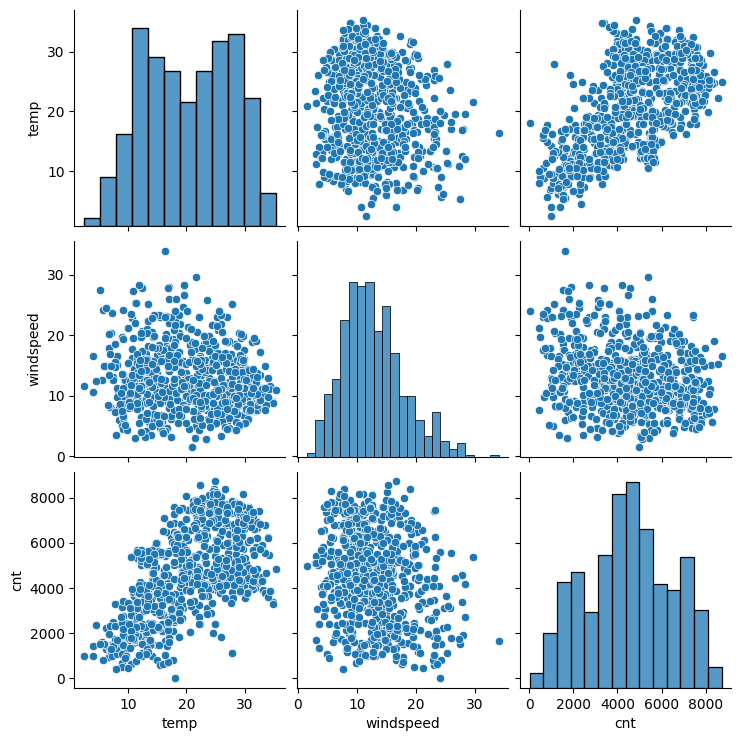

In [204]:
sns.pairplot(df[["temp","windspeed","cnt"]])

In [205]:
#Insight: above plot shows +ve correlation between temp and cnt

In [206]:
df["weathersit"].unique()

array(['Mist/Cloudy', 'Clear', 'Light Rain/Snow'], dtype=object)

In [207]:
df.dtypes

season         object
yr              int64
mnth           object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
windspeed     float64
cnt             int64
dtype: object

In [208]:
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist/Cloudy,14.110847,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist/Cloudy,14.902598,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Thursday,1,Mist/Cloudy,10.420847,23.458911,2114
726,spring,1,Dec,0,Friday,1,Mist/Cloudy,10.386653,10.416557,3095
727,spring,1,Dec,0,Saturday,0,Mist/Cloudy,10.386653,8.333661,1341
728,spring,1,Dec,0,Sunday,0,Clear,10.489153,23.500518,1796


In [209]:
#Preprocess the Data 
#Step 1: Using Encoding for non numerical data
#Step 2: Scaling numerical features
#Step 3: Split the dataset

In [210]:
#Step 1: Using Encoding for non numerical data
# season - one hot encoding
# mnth - label encoding
# weekday - one hot encoding
# weathersit - Label

In [211]:
# 1️⃣ One-Hot Encoding for 'season' and 'weekday'
df = pd.get_dummies(df, columns=['season', 'weekday'], drop_first=True)
df[df.select_dtypes(["bool"]).columns]=df.select_dtypes(["bool"]).astype(int)


# Label Encoding (mnth, weathersit)
le = LabelEncoder()
df['mnth'] = le.fit_transform(df['mnth'])
df['weathersit'] = le.fit_transform(df['weathersit'])

In [212]:
df

,yr,mnth,holiday,workingday,weathersit,temp,windspeed,cnt,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,4,0,0,2,14.110847,10.749882,985,1,0,0,0,1,0,0,0,0
1,0,4,0,0,2,14.902598,16.652113,801,1,0,0,0,0,1,0,0,0
2,0,4,0,1,0,8.050924,16.636703,1349,1,0,0,1,0,0,0,0,0
3,0,4,0,1,0,8.200000,10.739832,1562,1,0,0,0,0,0,0,1,0
4,0,4,0,1,0,9.305237,12.522300,1600,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,2,0,1,2,10.420847,23.458911,2114,1,0,0,0,0,0,1,0,0
726,1,2,0,1,2,10.386653,10.416557,3095,1,0,0,0,0,0,0,0,0
727,1,2,0,0,2,10.386653,8.333661,1341,1,0,0,0,1,0,0,0,0
728,1,2,0,0,0,10.489153,23.500518,1796,1,0,0,0,0,1,0,0,0


# New metrics Creation
1. temp_windspeed → Helps understand the joint effect of wind & temperature on rides.
2. yr_mnth → Combines year & month into a single trend feature.Captures long-term trends (e.g., increasing/decreasing bookings over time).
3. temp_category -> Binning temperature into groups (e.g., cold, moderate, hot), this can show bike demand for different climate categories.
4. windspeed_category → Binning windspeed into categories (e.g., calm, breezy, windy), allows checking how different wind levels affect bookings (e.g., very high wind might deter riders).
5. cnt_lag1 -> Previous day's bike count , Helps in time-series forecasting, as today's bookings may be similar to yesterday's.
6. cnt_rolling7 → 7-day moving average of cnt , Captures weekly trends 

In [213]:


#Substep1:  Interaction Features
df['temp_windspeed'] = df['temp'] * df['windspeed']
df['yr_mnth'] = df['yr'] * df['mnth']

#Substep2: Binned Features
df['temp_category'] = pd.cut(df['temp'], bins=[0, 10, 25, 40], labels=['Cold', 'Moderate', 'Hot'])
df['windspeed_category'] = pd.cut(df['windspeed'], bins=[0, 10, 20, 40], labels=['Low', 'Medium', 'High'])

#Substep3: Lag Features (For Time-Series Predictions)
df['cnt_lag1'] = df['cnt'].shift(1)
df['cnt_rolling7'] = df['cnt'].rolling(window=7).mean()


In [214]:
df.dtypes

yr                       int64
mnth                     int64
holiday                  int64
workingday               int64
weathersit               int64
temp                   float64
windspeed              float64
cnt                      int64
season_spring            int64
season_summer            int64
season_winter            int64
weekday_Monday           int64
weekday_Saturday         int64
weekday_Sunday           int64
weekday_Thursday         int64
weekday_Tuesday          int64
weekday_Wednesday        int64
temp_windspeed         float64
yr_mnth                  int64
temp_category         category
windspeed_category    category
cnt_lag1               float64
cnt_rolling7           float64
dtype: object

In [215]:

# Step 1: For RFE calculation.. Drop Categorical Columns, we can readd them
df_numeric = df.drop(columns=['temp_category', 'windspeed_category'])

In [216]:
print(df_numeric.isna().sum())


yr                   0
mnth                 0
holiday              0
workingday           0
weathersit           0
temp                 0
windspeed            0
cnt                  0
season_spring        0
season_summer        0
season_winter        0
weekday_Monday       0
weekday_Saturday     0
weekday_Sunday       0
weekday_Thursday     0
weekday_Tuesday      0
weekday_Wednesday    0
temp_windspeed       0
yr_mnth              0
cnt_lag1             1
cnt_rolling7         6
dtype: int64


In [217]:
df_numeric.shape

(730, 21)

In [218]:
df_numeric = df_numeric.dropna(subset=['cnt_lag1', 'cnt_rolling7'])

In [219]:
print(df_numeric.isna().sum())

yr                   0
mnth                 0
holiday              0
workingday           0
weathersit           0
temp                 0
windspeed            0
cnt                  0
season_spring        0
season_summer        0
season_winter        0
weekday_Monday       0
weekday_Saturday     0
weekday_Sunday       0
weekday_Thursday     0
weekday_Tuesday      0
weekday_Wednesday    0
temp_windspeed       0
yr_mnth              0
cnt_lag1             0
cnt_rolling7         0
dtype: int64


# RFE Calculation

In [220]:
#Model 1

In [221]:


# Step 2: Define X (Features) and y (Target)
X = df_numeric.drop(columns=['cnt'])  # Drop target variable 'cnt'
y = df_numeric['cnt']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Step 4: Apply RFE with Linear Regression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)  # Select 10 best features
rfe.fit(X_train, y_train)

# Step 5: Get Selected Feature Names
selected_features = X_train.columns[rfe.support_]
print("Top 10 Selected Features:", selected_features)


Top 10 Selected Features: Index(['yr', 'holiday', 'workingday', 'weathersit', 'season_spring',
       'season_summer', 'season_winter', 'weekday_Monday', 'weekday_Sunday',
       'weekday_Wednesday'],
      dtype='object')


In [222]:
X_selected=X[selected_features]

In [223]:
X_selected

,yr,holiday,workingday,weathersit,season_spring,season_summer,season_winter,weekday_Monday,weekday_Sunday,weekday_Wednesday
6,0,0,1,2,1,0,0,0,0,0
7,0,0,0,2,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,1,0
9,0,0,1,0,1,0,0,1,0,0
10,0,0,1,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,2,1,0,0,0,0,0
726,1,0,1,2,1,0,0,0,0,0
727,1,0,0,2,1,0,0,0,0,0
728,1,0,0,0,1,0,0,0,1,0


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=.2, random_state=100)

In [225]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(579, 10) (145, 10) (579,) (145,)


In [226]:
#Post feature selection, scaling is not required as everything is on low scale

In [227]:
#Training model
model.fit(X_train, y_train)

LinearRegression()

In [228]:
#Evaluate Model Performance
y_pred = model.predict(X_test)
print(y_pred.shape, y_test.shape)


(145,) (145,)


In [229]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 864343.5050129989
R² Score: 0.7436927585636133


In [230]:
df.dtypes

yr                       int64
mnth                     int64
holiday                  int64
workingday               int64
weathersit               int64
temp                   float64
windspeed              float64
cnt                      int64
season_spring            int64
season_summer            int64
season_winter            int64
weekday_Monday           int64
weekday_Saturday         int64
weekday_Sunday           int64
weekday_Thursday         int64
weekday_Tuesday          int64
weekday_Wednesday        int64
temp_windspeed         float64
yr_mnth                  int64
temp_category         category
windspeed_category    category
cnt_lag1               float64
cnt_rolling7           float64
dtype: object

#Model 2.1 with 14 params including 2 more derived metrics which we dropped in last model (Using stats model to get full summary)

In [231]:
df = pd.get_dummies(df, columns=['temp_category', 'windspeed_category'], drop_first=True)


In [232]:
df.dtypes

yr                             int64
mnth                           int64
holiday                        int64
workingday                     int64
weathersit                     int64
temp                         float64
windspeed                    float64
cnt                            int64
season_spring                  int64
season_summer                  int64
season_winter                  int64
weekday_Monday                 int64
weekday_Saturday               int64
weekday_Sunday                 int64
weekday_Thursday               int64
weekday_Tuesday                int64
weekday_Wednesday              int64
temp_windspeed               float64
yr_mnth                        int64
cnt_lag1                     float64
cnt_rolling7                 float64
temp_category_Moderate          bool
temp_category_Hot               bool
windspeed_category_Medium       bool
windspeed_category_High         bool
dtype: object

In [233]:
df.shape

(730, 25)

In [234]:
df.isna().sum()

yr                           0
mnth                         0
holiday                      0
workingday                   0
weathersit                   0
temp                         0
windspeed                    0
cnt                          0
season_spring                0
season_summer                0
season_winter                0
weekday_Monday               0
weekday_Saturday             0
weekday_Sunday               0
weekday_Thursday             0
weekday_Tuesday              0
weekday_Wednesday            0
temp_windspeed               0
yr_mnth                      0
cnt_lag1                     1
cnt_rolling7                 6
temp_category_Moderate       0
temp_category_Hot            0
windspeed_category_Medium    0
windspeed_category_High      0
dtype: int64

In [235]:
df.isnull().sum()

yr                           0
mnth                         0
holiday                      0
workingday                   0
weathersit                   0
temp                         0
windspeed                    0
cnt                          0
season_spring                0
season_summer                0
season_winter                0
weekday_Monday               0
weekday_Saturday             0
weekday_Sunday               0
weekday_Thursday             0
weekday_Tuesday              0
weekday_Wednesday            0
temp_windspeed               0
yr_mnth                      0
cnt_lag1                     1
cnt_rolling7                 6
temp_category_Moderate       0
temp_category_Hot            0
windspeed_category_Medium    0
windspeed_category_High      0
dtype: int64

In [236]:
df=df.dropna()

In [237]:
df[['temp_category_Moderate', 'temp_category_Hot', 
    'windspeed_category_Medium', 'windspeed_category_High']] = df[
    ['temp_category_Moderate', 'temp_category_Hot', 
     'windspeed_category_Medium', 'windspeed_category_High']
].astype(int)

In [238]:
X = df.drop(columns=['cnt'])  # Drop target variable 'cnt'
y = df['cnt']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Step 4: Apply RFE with Linear Regression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=14)  # Select 10 best features
rfe.fit(X_train, y_train)

# Step 5: Get Selected Feature Names
selected_features = X_train.columns[rfe.support_]
print("Top 14 Selected Features:", selected_features)

Top 14 Selected Features: Index(['yr', 'workingday', 'weathersit', 'season_spring', 'season_summer',
       'season_winter', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Tuesday', 'weekday_Wednesday', 'temp_category_Hot',
       'windspeed_category_Medium', 'windspeed_category_High'],
      dtype='object')


In [239]:
print(df.dtypes)

yr                             int64
mnth                           int64
holiday                        int64
workingday                     int64
weathersit                     int64
temp                         float64
windspeed                    float64
cnt                            int64
season_spring                  int64
season_summer                  int64
season_winter                  int64
weekday_Monday                 int64
weekday_Saturday               int64
weekday_Sunday                 int64
weekday_Thursday               int64
weekday_Tuesday                int64
weekday_Wednesday              int64
temp_windspeed               float64
yr_mnth                        int64
cnt_lag1                     float64
cnt_rolling7                 float64
temp_category_Moderate         int64
temp_category_Hot              int64
windspeed_category_Medium      int64
windspeed_category_High        int64
dtype: object


In [240]:
X = df[selected_features]  # Use the features selected after RFE/VIF
y = df['cnt']  # Target variable (bike demand)

# Add a constant (intercept) to the model
X = sm.add_constant(X)
print(X.dtypes)
model = sm.OLS(y, X).fit()
print(model.summary())

const                        float64
yr                             int64
workingday                     int64
weathersit                     int64
season_spring                  int64
season_summer                  int64
season_winter                  int64
weekday_Monday                 int64
weekday_Saturday               int64
weekday_Sunday                 int64
weekday_Tuesday                int64
weekday_Wednesday              int64
temp_category_Hot              int64
windspeed_category_Medium      int64
windspeed_category_High        int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     138.7
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          3.98e-192
Time:                        23:13:4

In [241]:
#Model 2.2 (Using same 14 features but sklearn library)

X_new = df[selected_features]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y, test_size=0.2, random_state=100)

lr_model2 = LinearRegression()
lr_model2.fit(X_train2, y_train2)

y_pred2 = lr_model2.predict(X_test2)
print("MSE (Model 2):", mean_squared_error(y_test2, y_pred2))
print("R² Score (Model 2):", r2_score(y_test2, y_pred2))


MSE (Model 2): 789307.552629034
R² Score (Model 2): 0.7659434700603079


Comparison between 2 models: After adding 'temp_category' and 'windspeed_category' helped improve model accuracy


| Metric        | Model 1        | Model 2.2        | Improvement            |
|--------------|---------------|---------------|------------------------|
| **MSE**      | 864343.51      | 789307.55     | Lower MSE → Better     |
| **R² Score** | 0.7437        | 0.7659        | Higher R² → Better     |


#Residual analysis for model 2 (Residual=Actual−Predicted)

In [242]:
# Compute residuals
residuals = y_test2 - y_pred2

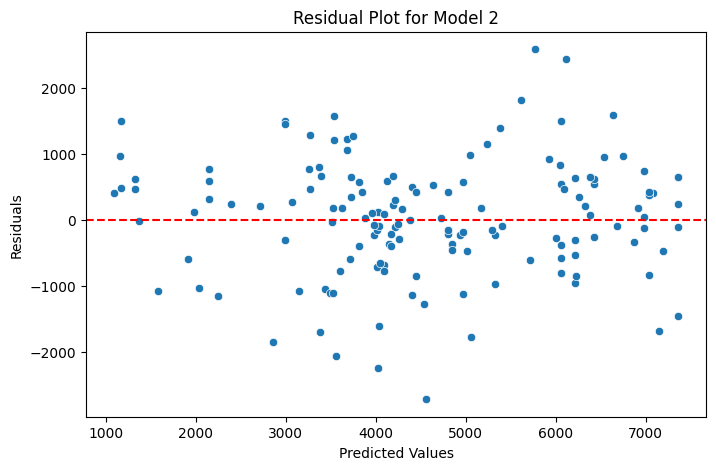

In [243]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred2, y=residuals)
plt.axhline(y=0, color='red', linestyle='dashed')  # Zero line
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 2")
plt.show()


In [244]:
#Above plot shows randomly distributed residuals around zero (sign of good model)

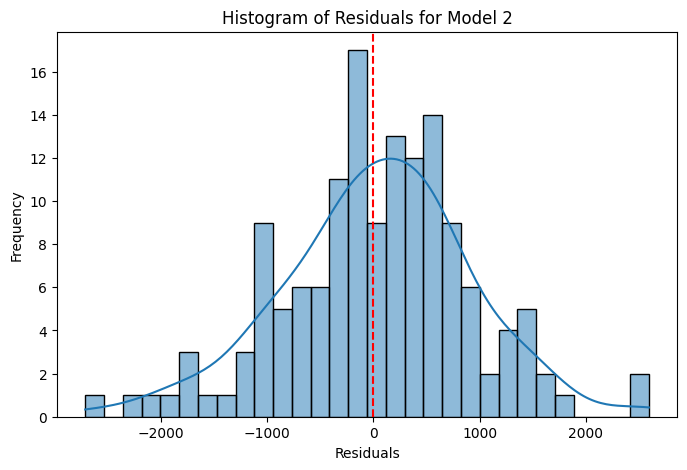

In [245]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='dashed')  # Zero line
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals for Model 2")
plt.show()

In [246]:
#Residuals are following a normal distribution. (sign of good model)